In [132]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection

from IPython.display import display

from keras_tqdm import TQDMNotebookCallback

import keras
from keras.models import Model
from keras.layers import Dense, Activation, Input, Add
from keras.optimizers import RMSprop
from keras_tqdm import TQDMNotebookCallback

# Generate some data

Generate some random "X" points within the unit square.

In [35]:
n = 300
X = pd.DataFrame(np.random.uniform(-1, 1, (n, 2)),
                 columns=['x1', 'x2'])
X.head()

,x1,x2
0,-0.165941,-0.146361
1,-0.463781,-0.736806
2,-0.921579,-0.949536
3,-0.456899,-0.076293
4,0.452487,-0.050257


We'll generate a few "Y" datasets of increasing difficulty.

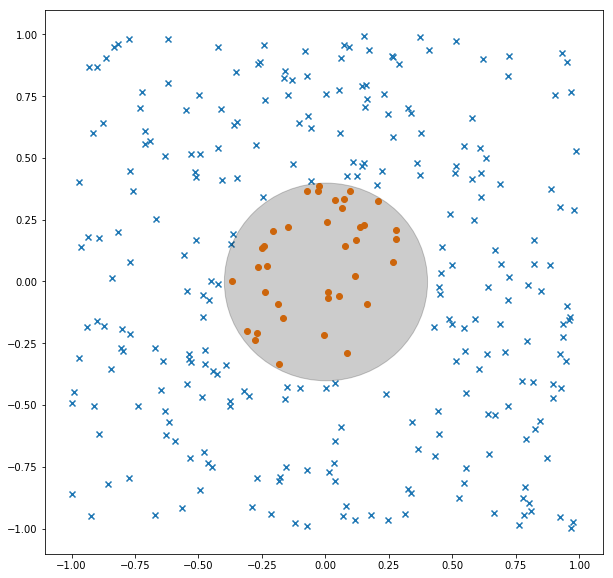

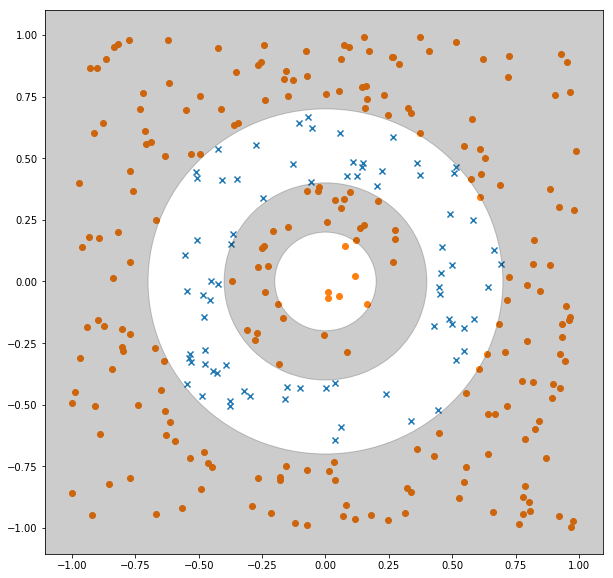

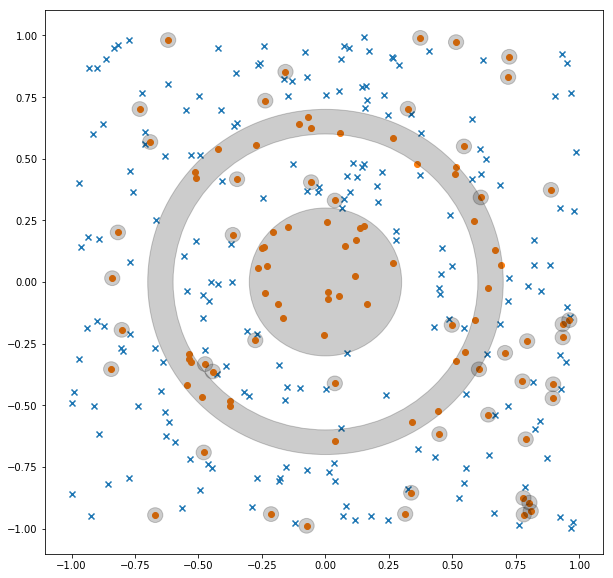

In [303]:
def easy_predicate(row):
    return row.x1**2 + row.x2**2 < 0.4**2

def medium_predicate(row):
    return (row.x1**2 + row.x2**2 < 0.4**2) or (row.x1**2 + row.x2**2 >= 0.7**2)

def hard_fixed_predicate(row):
    return ((row.x1**2 + row.x2**2 < 0.3**2) or 
            ((row.x1**2 + row.x2**2 >= 0.6**2) and (row.x1**2 + row.x2**2 < 0.7**2)))

def hard_predicate(row, p = 0.2):
    return hard_fixed_predicate(row) or  (np.random.rand() < p)

def dataset(data, predicate):
    return data.assign(y=lambda df: df.apply(lambda row: 1 if predicate(row) else 0, axis=1)) \
               .assign(y0=lambda df: (df['y'] == 0).astype(int)) \
               .assign(y1=lambda df: (df['y'] == 1).astype(int))

def plot_data(data, ax):
    market_dict = {0: 'x', 1: 'o'}
    for kind in market_dict:
        if 'yp' in data.columns:
            d = data[data.yp == kind]
        else:
            d = data[data.y == kind]
        plt.scatter(d.x1, d.x2, 
                    marker=market_dict[kind])
   
    if 'yp' in data.columns:
        patches = []
        for index, row in df.iterrows():
            if row.y != row.yp:
                patches.append(Circle((row.x1, row.x2), 0.03))
        ax.add_collection(PatchCollection(patches, alpha=0.3, color='red'))        
        
def plot_easy(df):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_data(df, ax)
    patches = []
    patches.append(Circle((0, 0), 0.4))
    ax.add_collection(PatchCollection(patches, alpha=0.2, color='black'))
    
def plot_medium(df):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_data(df, ax)
    patches = []
    patches.append(Wedge((0., 0.), 0.4, 0, 360, 0.2))
    patches.append(Wedge((0., 0.), 0.7, 0, 360, 11.5))
    ax.add_collection(PatchCollection(patches, alpha=0.2, color='black'))
    
def plot_hard(df):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_data(df, ax)
    patches = []
    patches.append(Circle((0., 0.), 0.3))
    patches.append(Wedge((0., 0.), 0.7, 0, 360, 0.1))
    for index, row in df.iterrows():
        if row.y and not hard_fixed_predicate(row):
            patches.append(Circle((row.x1, row.x2), 0.03))
        
    ax.add_collection(PatchCollection(patches, alpha=0.2, color='black'))
    
def plot_dataset(df, predicate):
    if predicate == easy_predicate:
        plot_easy(df)
    elif predicate == medium_predicate:
        plot_medium(df)
    elif predicate == hard_predicate:
        plot_hard(df)
       
    
predicates = [easy_predicate, medium_predicate, hard_predicate]
for pred in predicates:
    plot_dataset(dataset(X, pred), pred)

#X.apply(lambda x: x[1], axis=1)

In [304]:
def model_fit(df, depth=10, width=2, learning_rate=0.01, verbose=0):
    def resnet_block(in_tensor):
        out_tensor = Dense(1, activation='relu')(in_tensor)
        out_tensor = Dense(width, use_bias=False)(out_tensor)
        out_tensor = Add()([out_tensor, in_tensor])
        return out_tensor
        
    in_x = Input(shape=(width,))
    x = in_x
    for i in range(depth):
        x = resnet_block(x)
    x = Dense(2, activation='softmax')(x)
    
    early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=0.01, patience=100)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=50, min_lr=0.01 * learning_rate)
    
    opt = RMSprop(lr=learning_rate)
    model = Model(inputs=in_x, outputs=x)
    model.compile(optimizer=opt, loss='binary_crossentropy')
    
    model.fit(df[['x1', 'x2']].values, 
              df[['y0', 'y1']].values, 
              #callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],
              callbacks=[early_stopping, reduce_lr],
              epochs=1000, batch_size=100, verbose=verbose)
    
    return model

Fitting on dataset=medium_predicate
Epoch 1/1000
300/300 [==============================] - 6s - loss: 0.7551      
Epoch 2/1000
300/300 [==============================] - 0s - loss: 0.6921     
Epoch 3/1000
300/300 [==============================] - 0s - loss: 0.6618     
Epoch 4/1000
300/300 [==============================] - 0s - loss: 0.6408     
Epoch 5/1000
300/300 [==============================] - 0s - loss: 0.6257     
Epoch 6/1000
300/300 [==============================] - 0s - loss: 0.6134     
Epoch 7/1000
300/300 [==============================] - 0s - loss: 0.6038     
Epoch 8/1000
300/300 [==============================] - 0s - loss: 0.5958     
Epoch 9/1000
300/300 [==============================] - 0s - loss: 0.5901     
Epoch 10/1000
300/300 [==============================] - 0s - loss: 0.5839     
Epoch 11/1000
300/300 [==============================] - 0s - loss: 0.5793     
Epoch 12/1000
300/300 [==============================] - 0s - loss: 0.5761     
Epoch 13/100

300/300 [==============================] - 0s - loss: 0.4149     
Epoch 104/1000
300/300 [==============================] - 0s - loss: 0.4130     
Epoch 105/1000
300/300 [==============================] - 0s - loss: 0.4155     
Epoch 106/1000
300/300 [==============================] - 0s - loss: 0.4105     
Epoch 107/1000
300/300 [==============================] - 0s - loss: 0.4087     
Epoch 108/1000
300/300 [==============================] - 0s - loss: 0.4112     
Epoch 109/1000
300/300 [==============================] - 0s - loss: 0.4047     
Epoch 110/1000
300/300 [==============================] - 0s - loss: 0.4050     
Epoch 111/1000
300/300 [==============================] - 0s - loss: 0.4064     
Epoch 112/1000
300/300 [==============================] - 0s - loss: 0.4043     
Epoch 113/1000
300/300 [==============================] - 0s - loss: 0.4037     
Epoch 114/1000
300/300 [==============================] - 0s - loss: 0.4004     
Epoch 115/1000
300/300 [===================

300/300 [==============================] - 0s - loss: 0.3721     
Epoch 205/1000
300/300 [==============================] - 0s - loss: 0.3727     
Epoch 206/1000
300/300 [==============================] - 0s - loss: 0.3719     
Epoch 207/1000
300/300 [==============================] - 0s - loss: 0.3713     
Epoch 208/1000
300/300 [==============================] - 0s - loss: 0.3745     
Epoch 209/1000
300/300 [==============================] - 0s - loss: 0.3752     
Epoch 210/1000
300/300 [==============================] - 0s - loss: 0.3720     
Epoch 211/1000
300/300 [==============================] - 0s - loss: 0.3739     
Epoch 212/1000
300/300 [==============================] - 0s - loss: 0.3738     
Epoch 213/1000
300/300 [==============================] - 0s - loss: 0.3691     
Epoch 214/1000
300/300 [==============================] - 0s - loss: 0.3720     
Epoch 215/1000
300/300 [==============================] - 0s - loss: 0.3784     
Epoch 216/1000
300/300 [===================

300/300 [==============================] - 0s - loss: 0.3709     
Epoch 306/1000
300/300 [==============================] - 0s - loss: 0.3706     
Epoch 307/1000
300/300 [==============================] - 0s - loss: 0.3726     
Epoch 308/1000
300/300 [==============================] - 0s - loss: 0.3647     
Epoch 309/1000
300/300 [==============================] - 0s - loss: 0.3648     
Epoch 310/1000
300/300 [==============================] - 0s - loss: 0.3691     
Epoch 311/1000
300/300 [==============================] - 0s - loss: 0.3780     
Epoch 312/1000
300/300 [==============================] - 0s - loss: 0.3664     
Epoch 313/1000
300/300 [==============================] - 0s - loss: 0.3637     
Epoch 314/1000
288/300 [===========================>..] - ETA: 0s 

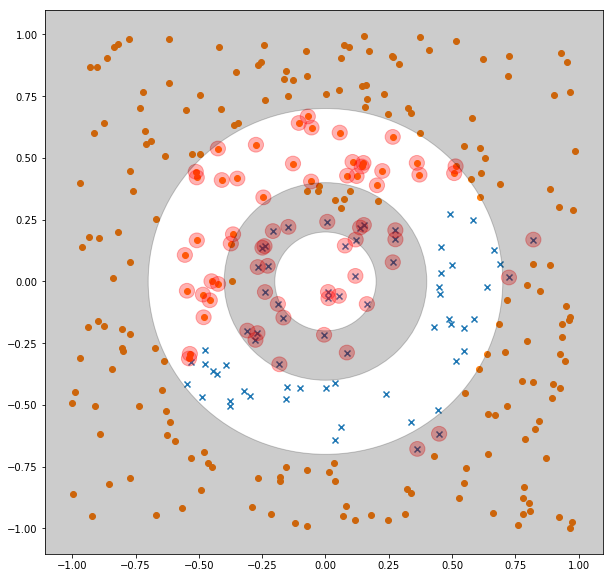

In [305]:
for pred in predicates[1:]:
    print("Fitting on dataset={}".format(pred.__name__))
    df = dataset(X, pred)
    model = model_fit(df, depth=2, verbose=1)
    values = model.predict(df[['x1', 'x2']].values, verbose=1)
    
    df['yp0'] = values[:, 0]
    df['yp1'] = values[:, 1]
    df['yp'] = (df['yp1'] > 0.5).astype(int)
    #df['yp'] = (values > 0.5).astype(int)
    
    plot_dataset(df, pred)
    break

In [273]:
pd.DataFrame(values).describe()

,0,1
count,3.000000e+02,300.000000
mean,2.575005e-01,0.742499
std,2.408013e-01,0.240801
min,9.115382e-14,0.187079
25%,1.933220e-02,0.539373
50%,1.948086e-01,0.805191
75%,4.606270e-01,0.980668
max,8.129213e-01,1.000000
